In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
train_problems = read_fatahi_dataset("../data/train_data.xlsx")
test_problems = read_fatahi_dataset("../data/fatahi.xlsx")

100%|██████████| 18/18 [00:00<?, ?it/s]


In [3]:
def dglgraph_fixed(graph, oper_max=20):
    ncolumns = graph.ndata['feat']['o'].shape[1]
    graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
    return graph

In [4]:
class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]
        graph = dglgraph(problem, gamma, delta)
        graph = dglgraph_fixed(graph)
        # graph.edata["feat"][os_type][:, 0] /= 10
        # graph.edata["feat"][ss_type] /= 100
        return graph.to(device)

In [5]:
info_train = {}
for idx in [int(i.split('_')[-2]) for i in glob('train_solutions/*') if 'op' in i]:
    info_train[idx] = {}
    info_train[idx]['gamma'] = np.load(f'train_solutions/gamma_{idx}_op.npy')
    info_train[idx]['delta'] = np.load(f'train_solutions/delta_{idx}_op.npy')
    info_train[idx]['problem'] = train_problems[idx]

In [6]:
info_test = {}
for idx in [int(i.split('_')[-2]) for i in glob('fatahi_solutions/*') if 'op' in i]:
    info_test[idx] = {}
    info_test[idx]['gamma'] = np.load(f'fatahi_solutions/gamma_{idx}_op.npy')
    info_test[idx]['delta'] = np.load(f'fatahi_solutions/delta_{idx}_op.npy')
    info_test[idx]['problem'] = train_problems[idx]

In [7]:
train_idx, test_idx = train_test_split(list(info_train.keys()),
                                       random_state=42,train_size=0.7)

In [8]:
train_dataset = GraphDataset([info_train[i]['problem'] for i in train_idx],
                             [info_train[i]['gamma'] for i in train_idx],
                             [info_train[i]['delta'] for i in train_idx])

test_dataset = GraphDataset([info_train[i]['problem'] for i in test_idx],
                             [info_train[i]['gamma'] for i in test_idx],
                             [info_train[i]['delta'] for i in test_idx])

# train_dataset = GraphDataset([info_train[i]['problem'] for i in sorted(info_train.keys())],
#                              [info_train[i]['gamma'] for i in sorted(info_train.keys())],
#                              [info_train[i]['delta'] for i in sorted(info_train.keys())])

# test_dataset = GraphDataset([info_test[i]['problem'] for i in sorted(info_test.keys())],
#                              [info_test[i]['gamma'] for i in sorted(info_test.keys())],
#                              [info_test[i]['delta'] for i in sorted(info_test.keys())])

In [9]:
train_dataset[0]

Graph(num_nodes={'o': 67, 's': 5},
      num_edges={('o', 'backward', 'o'): 75, ('o', 'forward', 'o'): 75, ('o', 'os', 's'): 245, ('s', 'so', 'o'): 245, ('s', 'ss', 's'): 25},
      metagraph=[('o', 'o', 'backward'), ('o', 'o', 'forward'), ('o', 's', 'os'), ('s', 'o', 'so'), ('s', 's', 'ss')])

In [10]:
train_loader = GraphDataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=10, shuffle=True)

In [11]:
from joblib import Parallel, delayed

def validate_objective(model, dataset):
    # test_objvalue = []
    # for i in range(len(dataset.problems)):
    #     pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
    #     test_objvalue.append(
    #         objvalue(dataset.problems[i], pred_gamma, pred_delta)
    #     )
    def process_objective(model, dataset, i):
        pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
        return objvalue(dataset.problems[i], pred_gamma, pred_delta)
    
    test_objvalue = Parallel(n_jobs=-1)(
        delayed(process_objective)(model, dataset, i) for i in range(len(dataset.problems))
    )
    return np.mean(test_objvalue)

In [12]:
i=0
gamma = info_train[i]['gamma']
delta = info_train[i]['delta']
problem = train_problems[i]

print(problem['operations'])
print(gamma.sum())
print(delta.sum())

[[1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0.]]
19.0
12.0


In [13]:
idx=5
gamma = info_train[idx]['gamma']
delta = info_train[idx]['delta']
for op_num in range(train_problems[idx]['operations'].shape[1]):
    city_list = []
    for i, sub_op in enumerate(np.nonzero(train_problems[idx]['operations'][:,op_num])[0]):
        c = np.nonzero(gamma[sub_op, op_num,:])
        city_list.append(c)
        if i != 0:
            print(city_list[i-1][0], c[0])
            print(delta[:,city_list[i-1],c,sub_op,op_num].reshape(-1))
    print('\n')

[3] [13]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[9] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[9] [13]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


[5] [5]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[5] [0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


[9] [11]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[11] [13]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


[11] [8]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[8] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


[7] [11]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[11] [13]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[9] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]




In [14]:
def print_all(loss_list_train, loss_list_test,
              objvalue_train, objvalue_test):
    plt.plot(loss_list_train, label='train loss')
    plt.plot(loss_list_test, label='test loss')
    plt.legend()
    plt.show()

    plt.plot(objvalue_train, label='train objective')
    plt.plot(objvalue_test, label='test objective')
    plt.legend()
    plt.show()

In [15]:
def run_experiment(model, lr=1e-4, num_epochs=1):
    optim = Adam(model.parameters(), lr=lr)

    loss_list_train = []
    objvalue_train = []
    loss_list_test = []
    objvalue_test = []
    for epoch in trange(num_epochs):
            ep_loss_train = []
            ep_loss_test = []
            for graph in train_loader:
                optim.zero_grad()
                # take initial info
                gamma_target = graph.edata["target"][os_type]
                delta_target = graph.edata["delta_target"][ss_type]
                mask = graph.edata["mask"][ss_type]
                # Forward pass
                logits, delta_logits = model(graph)
                # loss calculation
                operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                service_loss = F.cross_entropy(delta_logits[mask.bool()],
                                            delta_target[mask.bool()])

                loss = operation_loss + service_loss*0.5
                loss.backward()
                optim.step()
                ep_loss_train.append(loss.item())

            for graph in test_loader:
                with torch.no_grad():
                    # take initial info
                    gamma_target = graph.edata["target"][os_type]
                    delta_target = graph.edata["delta_target"][ss_type]
                    mask = graph.edata["mask"][ss_type]
                    # Forward pass
                    logits, delta_logits = model(graph)
                    # loss calculation
                    operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                    service_loss = F.cross_entropy(delta_logits[mask.bool()],
                                                delta_target[mask.bool()])
                    #loss = operation_loss + service_loss*0.5
                    loss = service_loss
                    ep_loss_test.append(loss.item())

            loss_list_train.append(np.mean(ep_loss_train))
            loss_list_test.append(np.mean(ep_loss_test))

            if (epoch + 1) % 10 == 0:
                objvalue_train.append(validate_objective(model, train_dataset))
                objvalue_test.append(validate_objective(model, test_dataset))

    print_all(loss_list_train, loss_list_test,
              objvalue_train, objvalue_test)
    return model

In [16]:
for dim in [5,10,15,20,30]:
    for lr in [1e-2, 1e-3, 1e-4, 1e-5]:
        print(dim, lr)
        run_experiment(out_dim=dim, lr=lr)

5 0.01


TypeError: run_experiment() got an unexpected keyword argument 'out_dim'

10 0.01


100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


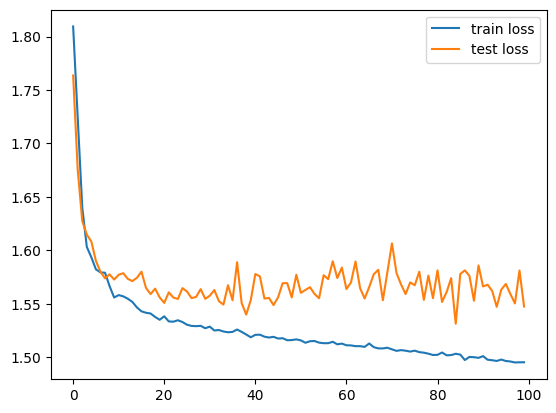

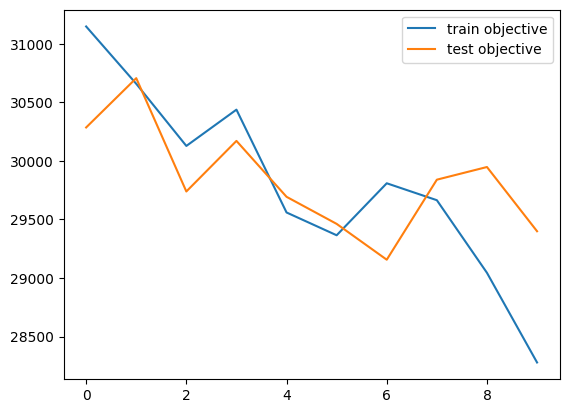

In [ ]:
for dim in [10]:
    for lr in [1e-2]:
        print(dim, lr)
        model = run_experiment(out_dim=dim, lr=lr)

In [ ]:
graph = train_dataset[2]
gamma_target = graph.edata["target"][os_type]
delta_target = graph.edata["delta_target"][ss_type]
mask = graph.edata["mask"][ss_type]

with torch.no_grad():
    logits, delta_logits = model(graph)

operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
service_loss = F.cross_entropy(delta_logits[mask.bool()],
                            delta_target[mask.bool()])

loss = operation_loss + service_loss*0.5

In [ ]:
graph.nodes('o')

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [ ]:
u, v = graph.edges(etype=('o', 'forward', 'o'))

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_edgelist([[i.item(), j.item()] for (i, j) in zip(u, v)], create_using=nx.DiGraph)

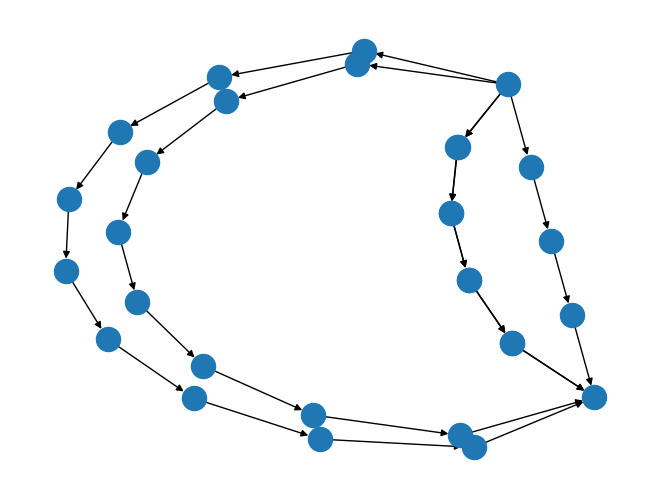

In [ ]:
nx.draw_kamada_kawai(G)

In [ ]:
import matplotlib.pyplot as plt

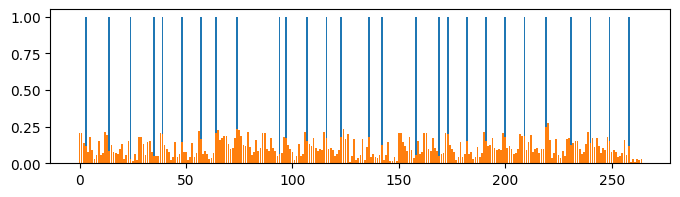

In [ ]:
plt.figure(figsize=(8, 2))
plt.bar(np.arange(len(gamma_target)), gamma_target.numpy()[:, 0])
plt.bar(np.arange(len(gamma_target)), torch.sigmoid(logits).numpy()[:, 0])
plt.show()

In [ ]:
from torch.utils.data import Subset

In [ ]:
train_loader = GraphDataLoader(Subset(train_dataset, [2]), batch_size=30, shuffle=True)
test_loader = GraphDataLoader(Subset(test_dataset, [0]), batch_size=10, shuffle=True)

In [ ]:
model = GNN(
    s_shape=1, o_shape=20, os_shape=2,ss_shape=10, 
    out_dim=256, n_layers=2
).to(device)
run_experiment(model, lr=0.01, num_epochs=100)

  0%|                                                                                             | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (169x266 and 267x256)

In [ ]:
with torch.no_grad():
    logits, delta_logits = model(graph)

In [ ]:
delta_preds = torch.zeros_like(delta_logits)
delta_preds[
    torch.arange(delta_preds.shape[0]), 
    torch.argmax(torch.softmax(delta_logits, 1), dim=1)
] = 1
delta_preds[delta_target.sum(dim=1) == 0] = 0

In [ ]:
#plt.figure(figsize=(10, 10))
#plt.imshow(delta_preds.numpy(), aspect='auto', cmap=plt.cm.hot)
#plt.imshow(delta_target.numpy(), aspect='auto', cmap=plt.cm.hot_r, alpha=0.4)
#plt.show()

In [ ]:
delta_proba = torch.softmax(delta_logits, 1)

In [ ]:
idx_nonzero = np.where(delta_target.sum(dim=1) != 0)[0]
i = idx_nonzero[6]

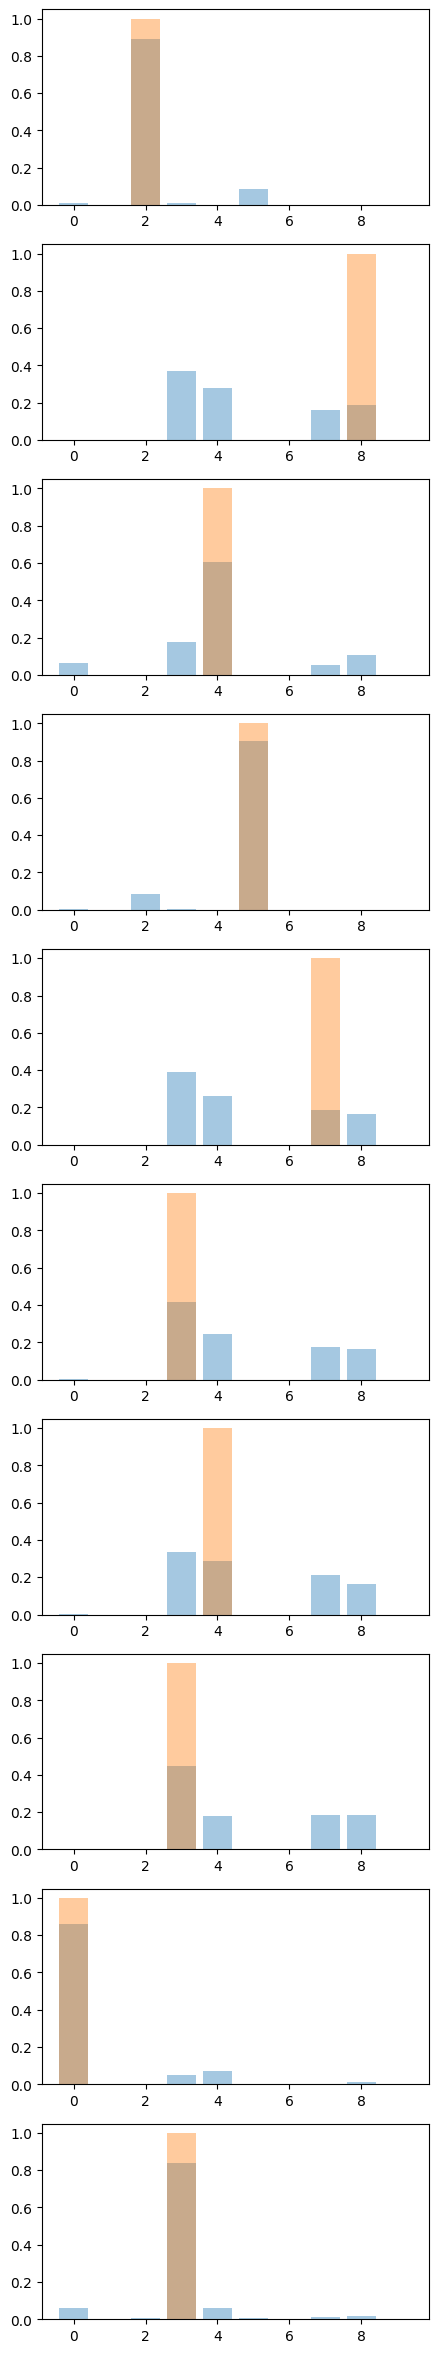

In [ ]:
plt.figure(figsize=(5, 3*len(idx_nonzero)))
j = 1
for i in idx_nonzero:
    plt.subplot(len(idx_nonzero), 1, j)
    plt.bar(np.arange(delta_proba.shape[1]), delta_proba[i], alpha=0.4)
    plt.bar(np.arange(delta_proba.shape[1]), delta_target[i], alpha=0.4)
    j += 1
plt.show()

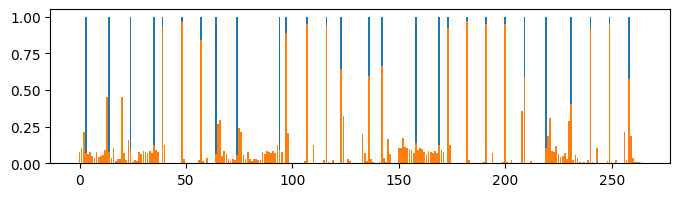

In [ ]:
plt.figure(figsize=(8, 2))
plt.bar(np.arange(len(gamma_target)), gamma_target.numpy()[:, 0])
plt.bar(np.arange(len(gamma_target)), torch.sigmoid(logits).numpy()[:, 0])
#plt.xlim(0, 100)
plt.show()